### Imports

In [1]:
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
# init model and set time limit at 30 minutes
model = gp.Model("scheduling sports leagues")
model.setParam('TimeLimit', 30*60)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-31
Set parameter TimeLimit to value 1800


### 1) Read data 

In [3]:
df = pd.read_csv('games_probs')
df = df.drop('Unnamed: 0', axis=1)
df['game_number'] = df.index
df

,home_team,away_team,home_team_number,away_team_number,home_goal_expect,away_goal_expect,game_number,draw,home_win,away_win
0,1. FC Köln,Hertha BSC,0.0,12.0,2.015497,0.696527,0,0.197913,0.666356,0.118515
1,1. FC Union Berlin,Bayer 04 Leverkusen,1.0,9.0,1.178653,1.778313,1,0.233189,0.251174,0.504455
2,1. FSV Mainz 05,RB Leipzig,2.0,13.0,1.296519,0.813891,2,0.287032,0.476531,0.234034
3,Arminia Bielefeld,SC Freiburg,3.0,14.0,0.618793,1.525726,3,0.256707,0.149640,0.588777
4,Bor. Mönchengladbach,Bayern München,4.0,10.0,1.426170,3.375478,4,0.129969,0.120475,0.620122
...,...,...,...,...,...,...,...,...,...,...
301,Arminia Bielefeld,RB Leipzig,3.0,13.0,0.589327,1.701772,301,0.231059,0.124238,0.636630
302,Bayer 04 Leverkusen,SC Freiburg,9.0,14.0,1.608862,1.525726,302,0.236785,0.393345,0.358871
303,FC Augsburg,SpVgg Greuther Fürth,6.0,15.0,2.406417,0.862367,303,0.168762,0.679189,0.115724
304,Bor. Mönchengladbach,TSG Hoffenheim,4.0,16.0,2.333733,1.653296,304,0.197046,0.499258,0.265059


In [4]:
# create list of teams 
teams = df['home_team'].drop_duplicates().to_dict()

# create list of 34 matchdays
days = list(range(1,34+1))

# create list of games 
games = df[['home_team','away_team']]

# create 3 scenarios
scenarios = ['home_win', 'draw', 'away_win']
scenarios_home = {'home_win':3, 'draw':1, 'away_win':0}
scenarios_away = {'home_win':0, 'draw':1, 'away_win':3}

### 2) Create variables

In [5]:
# binary decision variable for game g on matchday d
x = model.addVars(games.index, days, vtype=GRB.BINARY, name="x")

# binary variable if team m is partitipating in game g
p = model.addVars(games.index,teams,vtype=GRB.BINARY, name="p")

# binary variable if game g is home for team t
y = model.addVars(games.index,teams, vtype=GRB.BINARY, name="y")

# binary variable if team t has home match on matchday d 
home = model.addVars(days,teams,vtype=GRB.INTEGER, name='home')

# points after matchday d for team t
point = model.addVars(days,teams,vtype=GRB.CONTINUOUS,lb=0,name="point")

# variables for variance
variance = model.addVars(days, vtype=GRB.CONTINUOUS, name="variance")

In [6]:
# set p = 1, if team participate in game g 
for g in games.index:
    for t in teams:
        if (int(df['home_team_number'][df['game_number']==g])) == t or (int(df['away_team_number'][df['game_number']==g])) == t:
            model.addConstr(p[g,t] == 1)
        else:
            model.addConstr(p[g,t] == 0)

In [7]:
# set y = 1, if game g is home for team t 
for g in games.index:
    for t in teams:
        if (int(df['home_team_number'][df['game_number']==g]) == t):
            model.addConstr(y[g,t] == 1)
        else:
            model.addConstr(y[g,t] == 0)

In [8]:
# set expected point count for each team based on scenarios (win,draw,loss)  
for d in days:
    for g in games.index:
        for t in teams:
            if d==1: 
                if (int(df['home_team_number'][df['game_number']==g])) == t:
                    model.addConstr((x[g,d]==1)>>(point[d,t]==gp.quicksum(float(df[s][df['game_number']==g]*scenarios_home[s]) for s in scenarios)))
                if (int(df['away_team_number'][df['game_number']==g])) == t:    
                    model.addConstr((x[g,d]==1)>>(point[d,t]==gp.quicksum(float(df[s][df['game_number']==g]*scenarios_away[s]) for s in scenarios)))
            else:
                if (int(df['home_team_number'][df['game_number']==g])) == t:
                    model.addConstr((x[g,d]==1)>>(point[d,t]==point[d-1,t] + gp.quicksum(float(df[s][df['game_number']==g]*scenarios_home[s]) for s in scenarios)))
                if (int(df['away_team_number'][df['game_number']==g])) == t:    
                    model.addConstr((x[g,d]==1)>>(point[d,t]==point[d-1,t] + gp.quicksum(float(df[s][df['game_number']==g]*scenarios_away[s]) for s in scenarios)))

### 3) Define objective function

In [9]:
# variables for variance
mean = model.addVars(days, vtype=GRB.CONTINUOUS, name="mean")
diff_mean = model.addVars(days,[10,5,9], lb=-30, vtype=GRB.CONTINUOUS, name="diff_mean")

# calculate mean 
for d in days:
    model.addConstr(mean[d]==(point[d,10]+point[d,5]+point[d,9]) / 3)
    
# calculate squared difference of mean 
for d in days: 
    for i in [10,5,9]:
        model.addConstr(diff_mean[d,i] == pow(point[d,i]-mean[d], 2))

# calculate variance 
for d in days: 
    model.addConstr(variance[d]==gp.quicksum(diff_mean[d,i] for i in [10,5,9]) / 3)
    
obj = gp.quicksum(variance[d] for d in days)

model.setObjective(obj, GRB.MINIMIZE)

### 4) Set constraints

In [10]:
# each game is planed exactly ones
for g in games.index:
    model.addConstr(gp.quicksum(x[g,d] for d in days)==1)

# every team has one match on each game day 
for t in teams:
    for d in days:
            model.addConstr(gp.quicksum(p[g,t]*x[g,d] for g in games.index)==1)

# plan matches in rounds (mirrored round robin)
for g in games.index:
    for d in days: 
        if d<=17:
            if g<=152:
                model.addConstr((x[g,d]==1)>>(x[g+153,d+17]==1))
            else:    
                model.addConstr((x[g,d]==1)>>(x[g-153,d+17]==1))
        else:
            if g<=152:
                model.addConstr((x[g,d]==1)>>(x[g+153,d-17]==1))
            else:    
                model.addConstr((x[g,d]==1)>>(x[g-153,d-17]==1))

# set home variable of game days 
for t in teams:
    for d in days:
        model.addConstr(home[d,t] == gp.quicksum(y[g,t]*x[g,d] for g in games.index))

# maximum 2 home games in a row
for t in teams:
    for d in days:
        if d<33:
            model.addConstr(home[d,t]+home[d+1,t]+home[d+2,t] <= 2)

### 5) Optimization

In [11]:
model.params.NonConvex = 2
model.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 11966 rows, 22848 columns and 23420 nonzeros
Model fingerprint: 0x3362fbcd
Model has 1326 quadratic constraints
Model has 31212 general constraints
Variable types: 816 continuous, 22032 integer (21420 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  QMatrix range    [1e+00, 2e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]
  QRHS range       [1e+00, 1e+00]
  GenCon rhs range [6e-02, 3e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 10506 rows and 4456 columns
Presolve time: 0.38s
Presolved: 23390 rows, 27543 columns, 72729 nonzeros
Presolved model has 20808 SOS constraint(s)
Presolved model has 238 bilinear constraint(s)
Variable types: 21765 continuous, 5778 integer (5778 bina

 49370 36952    0.00000  362 1349  184.38615    0.00000   100%   602  755s
H49438 36952                     184.3861497    0.00000   100%   602  755s
 51416 38886    0.00000  367 1913  184.38615    0.00000   100%   589  768s
H51929 38886                     184.3861497    0.00000   100%   588  768s
 53938 39836    0.00000  372  732  184.38615    0.00000   100%   573  778s
 55048 40902    0.00000  373 1238  184.38615    0.00000   100%   568  790s
H55570 40902                     184.3861496    0.00000   100%   569  790s
 56218 42543    0.00000  381 1921  184.38615    0.00000   100%   567  802s
 57993 45133    0.00244  411 1608  184.38615    0.00000   100%   560  816s
 60787 47415    0.00000  323 1850  184.38615    0.00000   100%   543  827s
 63439 48661    0.00000  343 1733  184.38615    0.00000   100%   527  837s
 64971 49583    0.00000  363 1755  184.38615    0.00000   100%   522  845s
 66133 50407    0.00000  383 1964  184.38615    0.00000   100%   520  852s
 66961 51444    0.22831  

 214661 175671    0.09114  757  180  184.38615    0.00000   100%   279 1346s
 217645 177773    0.09933  865  997  184.38615    0.00000   100%   277 1352s
 219016 178884    0.07008  576 1208  184.38615    0.00000   100%   276 1356s
 221564 180339    0.12052  838 1089  184.38615    0.00000   100%   274 1362s
 222470 181607    0.12052  716 1413  184.38615    0.00000   100%   274 1365s
 225473 183699    0.12052  790 1115  184.38615    0.00000   100%   272 1372s
H226798 183699                     184.3861454    0.00000   100%   271 1372s
 226898 184778    0.09433  739 1250  184.38615    0.00000   100%   271 1375s
 229620 187915    0.09933  765 1139  184.38615    0.00000   100%   269 1382s
 232236 188356    0.09933  742 1292  184.38615    0.00000   100%   267 1386s
 234166 192322    0.09933  779  919  184.38615    0.00000   100%   266 1394s
 236915 193741  153.96910  841  107  184.38615    0.00000   100%   264 1397s
 238728 195113    0.12052  763 1288  184.38615    0.00000   100%   262 1401s

In [12]:
print(teams)

{0: '1. FC Köln ', 1: '1. FC Union Berlin ', 2: '1. FSV Mainz 05 ', 3: 'Arminia Bielefeld ', 4: 'Bor. Mönchengladbach ', 5: 'Borussia Dortmund ', 6: 'FC Augsburg ', 7: 'VfB Stuttgart ', 8: 'VfL Wolfsburg ', 9: 'Bayer 04 Leverkusen ', 10: 'Bayern München ', 11: 'Eintracht Frankfurt ', 12: 'Hertha BSC ', 13: 'RB Leipzig ', 14: 'SC Freiburg ', 15: 'SpVgg Greuther Fürth ', 16: 'TSG Hoffenheim ', 17: 'VfL Bochum '}


### 6) Generate optimized game plan

In [13]:
# get results 
from collections import defaultdict
games_planned = defaultdict(list)
for d in days:
    for g in games.index:
        if x[g,d].x > 0:
            games_planned[d].append(g)
            
# convert list to dataframe      
game_plan = pd.DataFrame.from_dict(games_planned).T.stack().reset_index().drop('level_1',axis=1)

In [14]:
# rename columns 
game_plan = game_plan.rename(columns={game_plan.columns[0]: 'matchday', game_plan.columns[1]: 'games'})

# join game_plan with games 
df_games = pd.merge(game_plan, games,  how='left', left_on=['games'], right_on = [games.index]).dropna()
df_games = df_games.rename(columns={df_games.columns[2]: 'home', df_games.columns[3]: 'away'})

print(df_games.head(10))

df_games.to_csv('game_plan.csv')

   matchday  games                 home                   away
0         1      1  1. FC Union Berlin    Bayer 04 Leverkusen 
1         1     38   Arminia Bielefeld         TSG Hoffenheim 
2         1     42          Hertha BSC   SpVgg Greuther Fürth 
3         1     62       VfL Wolfsburg   Bor. Mönchengladbach 
4         1    106         SC Freiburg    Eintracht Frankfurt 
5         1    123         FC Augsburg             VfL Bochum 
6         1    142       VfB Stuttgart         Bayern München 
7         1    155          RB Leipzig        1. FSV Mainz 05 
8         1    238          1. FC Köln      Borussia Dortmund 
9         2     52      TSG Hoffenheim          VfL Wolfsburg 


### 7) Calculate point count of statistic expected point value

In [15]:
# get data of home/away games
home_away = defaultdict(list)
for d in days:
    for t in teams:
            home_away[d].append(home[d,t].x)
                        
# convert list to dataframe      
home_df = pd.DataFrame.from_dict(home_away).T.stack().reset_index()

# rename columns 
home_df = home_df.rename(columns={home_df.columns[0]: 'Matchday', home_df.columns[1]: 'Team', home_df.columns[2]: 'Home_Game'})

# filter home/away games for 1 team 
test = home_df[home_df['Team']==10]

In [16]:
# get point ranking of teams 
ranking_points = defaultdict(list)
for d in days:
    for t in teams:
        ranking_points[d].append(point[d,t].x)
        
# convert list to dataframe      
ranking = pd.DataFrame.from_dict(ranking_points).T.stack().reset_index()

# rename columns 
ranking = ranking.rename(columns={ranking.columns[0]: 'Matchday', ranking.columns[1]: 'Team', ranking.columns[2]: 'Points'})
ranking.to_csv('erwartungswerte.csv')


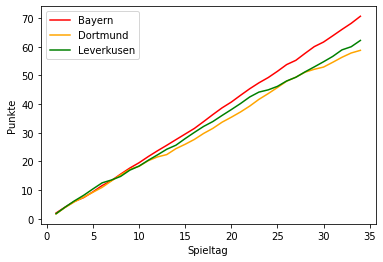

In [17]:
# visualize results 
plt.plot(days, ranking['Points'][ranking['Team'] == 10], label = "Bayern", color="red")
plt.plot(days, ranking['Points'][ranking['Team'] == 5], label = "Dortmund", color="orange")
plt.plot(days, ranking['Points'][ranking['Team'] == 9], label = "Leverkusen", color="green")
plt.xlabel("Spieltag")
plt.ylabel("Punkte")
plt.legend()
plt.show()        

### 8) Comparison with actual results of season 21/22

In [18]:
# get df with actual points of matches 
actual_results = pd.read_csv('results_prepared')
actual_results = actual_results.drop(['Unnamed: 0','index'], axis=1)

# merge actual results with optimized game plan
df_games_new = pd.merge(df_games, actual_results,  how='left', left_on=['games'], right_on = ['game_number'])
df_games_new = df_games_new[['matchday','home','away','home_points','away_points']]

In [19]:
# get point count per team and matchday
home_points = df_games_new
away_points = df_games_new
home_points = home_points[['matchday','home','home_points']]
away_points = away_points[['matchday','away','away_points']]
home_points = home_points.rename(columns={home_points.columns[1]: 'Team',home_points.columns[2]: 'Points'})
away_points = away_points.rename(columns={away_points.columns[1]: 'Team',away_points.columns[2]: 'Points'})
count = pd.concat([home_points,away_points]).sort_values('matchday')

# create point counter df 
count['Point_Count'] = 0

for t in teams:
    for i in range(1,35):
        if i==1:
            count['Point_Count'][(count['matchday']==i) & (count['Team']==teams.get(t))] = count['Points'][(count['matchday']==i) & (count['Team']==teams.get(t))]
        else:
            count['Point_Count'][(count['matchday']==i) & (count['Team']==teams.get(t))]  = int(count['Point_Count'][(count['matchday']==i-1) & (count['Team']==teams.get(t))]) + count['Points'][(count['matchday']==i) & (count['Team']==teams.get(t))]

In [26]:
# ranking after season
count[count['matchday']==34]

,matchday,Team,Points,Point_Count
303,34,RB Leipzig,3.0,58
302,34,VfL Wolfsburg,3.0,42
301,34,FC Augsburg,0.0,38
299,34,SC Freiburg,0.0,55
298,34,Arminia Bielefeld,0.0,28
297,34,VfB Stuttgart,1.0,33
300,34,1. FC Union Berlin,0.0,57
305,34,1. FC Köln,0.0,52
304,34,1. FSV Mainz 05,0.0,46
303,34,Hertha BSC,0.0,33


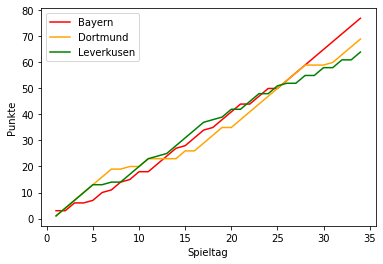

In [24]:
# visualize actual results with optimized game plan
plt.plot(count['matchday'][count['Team']=='Bayern München '], count['Point_Count'][count['Team']=='Bayern München '], label = "Bayern", color="red")
plt.plot(count['matchday'][count['Team']=='Borussia Dortmund '], count['Point_Count'][count['Team']=='Borussia Dortmund '], label = "Dortmund", color="orange")
plt.plot(count['matchday'][count['Team']=='Bayer 04 Leverkusen '], count['Point_Count'][count['Team']=='Bayer 04 Leverkusen '], label = "Leverkusen", color="green")
plt.xlabel("Spieltag")
plt.ylabel("Punkte")
plt.legend()
plt.show()      

### 9) Export  for later use & visualization

In [25]:
# filter top 3 teams 
count_bayern = count[count['Team']=='Bayern München ']
count_dortmund = count[count['Team']=='Borussia Dortmund ']
count_leverkusen = count[count['Team']=='Bayer 04 Leverkusen ']

# save points of top 3 teams
points_top3 = count[(count.Team=='Bayern München ') | (count.Team=='Bayer 04 Leverkusen ')  | (count.Team=='Borussia Dortmund ')]
points_top3.to_csv('points_top3_opt.csv')

# save points seperated for each team 
count_bayern.to_csv('count_bayern_opt.csv')
count_dortmund.to_csv('count_dortmund_opt.csv')
count_leverkusen.to_csv('count_leverkusen_opt.csv')